In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats

experiment = 'Exp1'

all_data = pd.read_csv('total_data.csv')
all_data = all_data[all_data['Experiment']==experiment]
all_data = all_data.drop(columns=['Unnamed: 0','TransDate','Test_name','Transect','Transect_Num','Experiment','Dist_Travelled'])


data_summary = pd.read_csv('data_summary.csv')
experiment_meta_data = data_summary[data_summary['Experiment']==experiment]
boat_lat = experiment_meta_data['boat.lat'].values[0]
boat_lon = experiment_meta_data['boat.lon'].values[0]
wind_dir = experiment_meta_data['Wind_Dir'].values[0]
wind_speed = experiment_meta_data['WindSpeed'].values[0]

all_data['dist_lat']=(all_data['gps.lat']-boat_lat)*111000
all_data['dist_lon']=(all_data['gps.lon']-boat_lon)*111000

all_data['x']=all_data['dist_lon']*np.cos(90-wind_dir+180) + all_data['dist_lat']*np.sin(90-wind_dir+180)
all_data['y']=all_data['dist_lon']*np.cos(180-wind_dir+180) + all_data['dist_lat']*np.sin(180-wind_dir+180)
all_data['z']=all_data['altitudeRelative']



In [2]:
def C_func(x,y,z,u,a,b,Q,H):
    C = Q/(2*a*x**b*np.pi*u)*(np.exp(-(y**2)/(2*a*x**b)))*(np.exp(-(z-H)**2/(2*a*x**b))+np.exp(-(z+H)**2/(2*a*x**b)))
    return C

In [3]:
def traceplots(x, xnames=None, title=None):
    N, d = x.shape
    fig = plt.figure()
    left, tracewidth, histwidth = 0.1, 0.65, 0.15
    bottom, rowheight = 0.1, 0.8/d
    spacing = 0.05
    
    for i in range(d):
        # Set the location of the trace and histogram viewports,
        # starting with the first dimension from the bottom of the canvas
        rowbottom = bottom + i*rowheight
        rect_trace = (left, rowbottom, tracewidth, rowheight)
        rect_hist = (left + tracewidth, rowbottom, histwidth, rowheight)
        # First set of trace plot axes
        if i == 0:
            ax_trace = fig.add_axes(rect_trace)
            ax_trace.plot(x[:,i])
            ax_trace.set_xlabel("Sample Count")
            ax_tr0 = ax_trace
        # Other sets of trace plot axes that share the first trace's x-axis
        # Make tick labels invisible so they don't clutter up the plot
        elif i > 0:
            ax_trace = fig.add_axes(rect_trace, sharex=ax_tr0)
            ax_trace.plot(x[:,i])
            plt.setp(ax_trace.get_xticklabels(), visible=False)
        # Title at the top
        if i == d-1 and title is not None:
            plt.title(title)
        # Trace y-axis labels
        if xnames is not None:
            ax_trace.set_ylabel(xnames[i])
        # Trace histograms at the right
        ax_hist = fig.add_axes(rect_hist, sharey=ax_trace)
        ax_hist.hist(x[:,i], orientation='horizontal', bins=50)
        plt.setp(ax_hist.get_xticklabels(), visible=False)
        plt.setp(ax_hist.get_yticklabels(), visible=False)
        xlim = ax_hist.get_xlim()
        ax_hist.set_xlim([xlim[0], 1.1*xlim[1]])

In [4]:
sigma_data = 0.1

a_0 = 0.33
alpha = 1

b_0 = 0.86
beta = 1

Q_0 = 1.1e-3
sigma_Q = 1e-3

u = wind_speed
H = 0

abQ_0=np.array([a_0,b_0,Q_0])
cov = np.array([[alpha,0,0],
                [0,beta,0],
                [0,0,sigma_Q]])

def log_likelihood(abQ,u,H,all_data,sigma_data):
    log_lhood = 0
    for i in range(all_data.shape[0]):
        x = all_data['x'].values[i]
        y = all_data['y'].values[i]
        z = all_data['z'].values[i]
        C = all_data['Concentration'].values[i]*0.01**3

        log_lhood+=-(C_func(x,y,z,u,abQ[0],abQ[1],abQ[2],H)-C)**2/(2*sigma_data**2)
    return log_lhood

def log_cond_prob_abQ(abQ,abQ_0,cov,log_lhood):
    return -(abQ-abQ_0)@np.linalg.inv(2*cov)@(abQ-abQ_0).T + log_lhood

def sample_abQ(abQ,abQ_0,cov,u,H,all_data,sigma_data,ss):
    abQ_sample = np.zeros(abQ.shape)
    # MCMC sampler
    current_abQ = abQ
    proposal_density = stats.multivariate_normal(mean=current_abQ, cov=ss)
    proposed_abQ = proposal_density.rvs()

    log_l_prop_abQ = log_likelihood(proposed_abQ,u,H,all_data,sigma_data)
    log_p_prop_abQ = log_cond_prob_abQ(proposed_abQ,abQ_0,cov,log_l_prop_abQ)
    
    log_l_curr_abQ = log_likelihood(current_abQ,u,H,all_data,sigma_data)
    log_p_curr_abQ = log_cond_prob_abQ(current_abQ,abQ_0,cov,log_l_curr_abQ)

    log_accept = log_p_prop_abQ - log_p_curr_abQ  
    if np.random.uniform(low=0, high=1) < np.exp(log_accept):
        abQ_sample = proposed_abQ
    else:
        abQ_sample = current_abQ
    return abQ_sample

def sample_process(N_samples,ss,abQ_0,cov,u,H,all_data,sigma_data,abQ_init=abQ_0):
    abQ_samples = []
    abQ_means = []

    # Set initial parameters
    abQ = abQ_init
    count=0
    # Run sampler
    for j in range(N_samples):
        count+=1
        print('Running Sample '+str(count))
        abQ = sample_abQ(abQ,abQ_0,cov,u,H,all_data,sigma_data,ss)

        abQ_samples.append(abQ.T)
        abQ_means.append(np.mean(abQ_samples,axis=0))

    return abQ_samples, abQ_means
    # Plot sample results

ss = [0.1,0.1,1e-4]
N_samples = 10000

abQ_samples,abQ_means = sample_process(N_samples,ss,abQ_0,cov,u,H,all_data,sigma_data)

Running Sample 1
Running Sample 2
Running Sample 3
Running Sample 4


C:\Users\samue\AppData\Local\Temp/ipykernel_26280/2006269487.py:28: RuntimeWarning: overflow encountered in double_scalars
  log_lhood+=-(C_func(x,y,z,u,abQ[0],abQ[1],abQ[2],H)-C)**2/(2*sigma_data**2)
C:\Users\samue\AppData\Local\Temp/ipykernel_26280/633881575.py:2: RuntimeWarning: overflow encountered in exp
  C = Q/(2*a*x**b*np.pi*u)*(np.exp(-(y**2)/(2*a*x**b)))*(np.exp(-(z-H)**2/(2*a*x**b))+np.exp(-(z+H)**2/(2*a*x**b)))
C:\Users\samue\AppData\Local\Temp/ipykernel_26280/633881575.py:2: RuntimeWarning: overflow encountered in double_scalars
  C = Q/(2*a*x**b*np.pi*u)*(np.exp(-(y**2)/(2*a*x**b)))*(np.exp(-(z-H)**2/(2*a*x**b))+np.exp(-(z+H)**2/(2*a*x**b)))


Running Sample 5
Running Sample 6
Running Sample 7
Running Sample 8
Running Sample 9
Running Sample 10
Running Sample 11
Running Sample 12
Running Sample 13
Running Sample 14
Running Sample 15
Running Sample 16
Running Sample 17
Running Sample 18
Running Sample 19
Running Sample 20
Running Sample 21
Running Sample 22
Running Sample 23
Running Sample 24
Running Sample 25
Running Sample 26
Running Sample 27
Running Sample 28
Running Sample 29
Running Sample 30
Running Sample 31
Running Sample 32
Running Sample 33
Running Sample 34
Running Sample 35
Running Sample 36
Running Sample 37
Running Sample 38
Running Sample 39
Running Sample 40
Running Sample 41
Running Sample 42
Running Sample 43
Running Sample 44
Running Sample 45
Running Sample 46
Running Sample 47
Running Sample 48
Running Sample 49
Running Sample 50
Running Sample 51
Running Sample 52
Running Sample 53
Running Sample 54
Running Sample 55
Running Sample 56
Running Sample 57
Running Sample 58
Running Sample 59
Running Sample 

Running Sample 442
Running Sample 443
Running Sample 444
Running Sample 445
Running Sample 446
Running Sample 447
Running Sample 448
Running Sample 449
Running Sample 450
Running Sample 451
Running Sample 452
Running Sample 453
Running Sample 454
Running Sample 455
Running Sample 456
Running Sample 457
Running Sample 458
Running Sample 459
Running Sample 460
Running Sample 461
Running Sample 462
Running Sample 463
Running Sample 464
Running Sample 465
Running Sample 466
Running Sample 467
Running Sample 468
Running Sample 469
Running Sample 470
Running Sample 471
Running Sample 472
Running Sample 473
Running Sample 474
Running Sample 475
Running Sample 476
Running Sample 477
Running Sample 478
Running Sample 479
Running Sample 480
Running Sample 481
Running Sample 482
Running Sample 483
Running Sample 484
Running Sample 485
Running Sample 486
Running Sample 487
Running Sample 488
Running Sample 489
Running Sample 490
Running Sample 491
Running Sample 492
Running Sample 493
Running Samp

Running Sample 874
Running Sample 875
Running Sample 876
Running Sample 877
Running Sample 878
Running Sample 879
Running Sample 880
Running Sample 881
Running Sample 882
Running Sample 883
Running Sample 884
Running Sample 885
Running Sample 886
Running Sample 887
Running Sample 888
Running Sample 889
Running Sample 890
Running Sample 891
Running Sample 892
Running Sample 893
Running Sample 894
Running Sample 895
Running Sample 896
Running Sample 897
Running Sample 898
Running Sample 899
Running Sample 900
Running Sample 901
Running Sample 902
Running Sample 903
Running Sample 904
Running Sample 905
Running Sample 906
Running Sample 907
Running Sample 908
Running Sample 909
Running Sample 910
Running Sample 911
Running Sample 912
Running Sample 913
Running Sample 914
Running Sample 915
Running Sample 916
Running Sample 917
Running Sample 918
Running Sample 919
Running Sample 920
Running Sample 921
Running Sample 922
Running Sample 923
Running Sample 924
Running Sample 925
Running Samp

Running Sample 1290
Running Sample 1291
Running Sample 1292
Running Sample 1293
Running Sample 1294
Running Sample 1295
Running Sample 1296
Running Sample 1297
Running Sample 1298
Running Sample 1299
Running Sample 1300
Running Sample 1301
Running Sample 1302
Running Sample 1303
Running Sample 1304
Running Sample 1305
Running Sample 1306
Running Sample 1307
Running Sample 1308
Running Sample 1309
Running Sample 1310
Running Sample 1311
Running Sample 1312
Running Sample 1313
Running Sample 1314
Running Sample 1315
Running Sample 1316
Running Sample 1317
Running Sample 1318
Running Sample 1319
Running Sample 1320
Running Sample 1321
Running Sample 1322
Running Sample 1323
Running Sample 1324
Running Sample 1325
Running Sample 1326
Running Sample 1327
Running Sample 1328
Running Sample 1329
Running Sample 1330
Running Sample 1331
Running Sample 1332
Running Sample 1333
Running Sample 1334
Running Sample 1335
Running Sample 1336
Running Sample 1337
Running Sample 1338
Running Sample 1339


Running Sample 1700
Running Sample 1701
Running Sample 1702
Running Sample 1703
Running Sample 1704
Running Sample 1705
Running Sample 1706
Running Sample 1707
Running Sample 1708
Running Sample 1709
Running Sample 1710
Running Sample 1711
Running Sample 1712
Running Sample 1713
Running Sample 1714
Running Sample 1715
Running Sample 1716
Running Sample 1717
Running Sample 1718
Running Sample 1719
Running Sample 1720
Running Sample 1721
Running Sample 1722
Running Sample 1723
Running Sample 1724
Running Sample 1725
Running Sample 1726
Running Sample 1727
Running Sample 1728
Running Sample 1729
Running Sample 1730
Running Sample 1731
Running Sample 1732
Running Sample 1733
Running Sample 1734
Running Sample 1735
Running Sample 1736
Running Sample 1737
Running Sample 1738
Running Sample 1739
Running Sample 1740
Running Sample 1741
Running Sample 1742
Running Sample 1743
Running Sample 1744
Running Sample 1745
Running Sample 1746
Running Sample 1747
Running Sample 1748
Running Sample 1749


Running Sample 2110
Running Sample 2111
Running Sample 2112
Running Sample 2113
Running Sample 2114
Running Sample 2115
Running Sample 2116
Running Sample 2117
Running Sample 2118
Running Sample 2119
Running Sample 2120
Running Sample 2121
Running Sample 2122
Running Sample 2123
Running Sample 2124
Running Sample 2125
Running Sample 2126
Running Sample 2127
Running Sample 2128
Running Sample 2129
Running Sample 2130
Running Sample 2131
Running Sample 2132
Running Sample 2133
Running Sample 2134
Running Sample 2135
Running Sample 2136
Running Sample 2137
Running Sample 2138
Running Sample 2139
Running Sample 2140
Running Sample 2141
Running Sample 2142
Running Sample 2143
Running Sample 2144
Running Sample 2145
Running Sample 2146
Running Sample 2147
Running Sample 2148
Running Sample 2149
Running Sample 2150
Running Sample 2151
Running Sample 2152
Running Sample 2153
Running Sample 2154
Running Sample 2155
Running Sample 2156
Running Sample 2157
Running Sample 2158
Running Sample 2159


Running Sample 2520
Running Sample 2521
Running Sample 2522
Running Sample 2523
Running Sample 2524
Running Sample 2525
Running Sample 2526
Running Sample 2527
Running Sample 2528
Running Sample 2529
Running Sample 2530
Running Sample 2531
Running Sample 2532
Running Sample 2533
Running Sample 2534
Running Sample 2535
Running Sample 2536
Running Sample 2537
Running Sample 2538
Running Sample 2539
Running Sample 2540
Running Sample 2541
Running Sample 2542
Running Sample 2543
Running Sample 2544
Running Sample 2545
Running Sample 2546
Running Sample 2547
Running Sample 2548
Running Sample 2549
Running Sample 2550
Running Sample 2551
Running Sample 2552
Running Sample 2553
Running Sample 2554
Running Sample 2555
Running Sample 2556
Running Sample 2557
Running Sample 2558
Running Sample 2559
Running Sample 2560
Running Sample 2561
Running Sample 2562
Running Sample 2563
Running Sample 2564
Running Sample 2565
Running Sample 2566
Running Sample 2567
Running Sample 2568
Running Sample 2569


Running Sample 2930
Running Sample 2931
Running Sample 2932
Running Sample 2933
Running Sample 2934
Running Sample 2935
Running Sample 2936
Running Sample 2937
Running Sample 2938
Running Sample 2939
Running Sample 2940
Running Sample 2941
Running Sample 2942
Running Sample 2943
Running Sample 2944
Running Sample 2945
Running Sample 2946
Running Sample 2947
Running Sample 2948
Running Sample 2949
Running Sample 2950
Running Sample 2951
Running Sample 2952
Running Sample 2953
Running Sample 2954
Running Sample 2955
Running Sample 2956
Running Sample 2957
Running Sample 2958
Running Sample 2959
Running Sample 2960
Running Sample 2961
Running Sample 2962
Running Sample 2963
Running Sample 2964
Running Sample 2965
Running Sample 2966
Running Sample 2967
Running Sample 2968
Running Sample 2969
Running Sample 2970
Running Sample 2971
Running Sample 2972
Running Sample 2973
Running Sample 2974
Running Sample 2975
Running Sample 2976
Running Sample 2977
Running Sample 2978
Running Sample 2979


Running Sample 3340
Running Sample 3341
Running Sample 3342
Running Sample 3343
Running Sample 3344
Running Sample 3345
Running Sample 3346
Running Sample 3347
Running Sample 3348
Running Sample 3349
Running Sample 3350
Running Sample 3351
Running Sample 3352
Running Sample 3353
Running Sample 3354
Running Sample 3355
Running Sample 3356
Running Sample 3357
Running Sample 3358
Running Sample 3359
Running Sample 3360
Running Sample 3361
Running Sample 3362
Running Sample 3363
Running Sample 3364
Running Sample 3365
Running Sample 3366
Running Sample 3367
Running Sample 3368
Running Sample 3369
Running Sample 3370
Running Sample 3371
Running Sample 3372
Running Sample 3373
Running Sample 3374
Running Sample 3375
Running Sample 3376
Running Sample 3377
Running Sample 3378
Running Sample 3379
Running Sample 3380
Running Sample 3381
Running Sample 3382
Running Sample 3383
Running Sample 3384
Running Sample 3385
Running Sample 3386
Running Sample 3387
Running Sample 3388
Running Sample 3389


Running Sample 3750
Running Sample 3751
Running Sample 3752
Running Sample 3753
Running Sample 3754
Running Sample 3755
Running Sample 3756
Running Sample 3757
Running Sample 3758
Running Sample 3759
Running Sample 3760
Running Sample 3761
Running Sample 3762
Running Sample 3763
Running Sample 3764
Running Sample 3765
Running Sample 3766
Running Sample 3767
Running Sample 3768
Running Sample 3769
Running Sample 3770
Running Sample 3771
Running Sample 3772
Running Sample 3773
Running Sample 3774
Running Sample 3775
Running Sample 3776
Running Sample 3777
Running Sample 3778
Running Sample 3779
Running Sample 3780
Running Sample 3781
Running Sample 3782
Running Sample 3783
Running Sample 3784
Running Sample 3785
Running Sample 3786
Running Sample 3787
Running Sample 3788
Running Sample 3789
Running Sample 3790
Running Sample 3791
Running Sample 3792
Running Sample 3793
Running Sample 3794
Running Sample 3795
Running Sample 3796
Running Sample 3797
Running Sample 3798
Running Sample 3799


Running Sample 4160
Running Sample 4161
Running Sample 4162
Running Sample 4163
Running Sample 4164
Running Sample 4165
Running Sample 4166
Running Sample 4167
Running Sample 4168
Running Sample 4169
Running Sample 4170
Running Sample 4171
Running Sample 4172
Running Sample 4173
Running Sample 4174
Running Sample 4175
Running Sample 4176
Running Sample 4177
Running Sample 4178
Running Sample 4179
Running Sample 4180
Running Sample 4181
Running Sample 4182
Running Sample 4183
Running Sample 4184
Running Sample 4185
Running Sample 4186
Running Sample 4187
Running Sample 4188
Running Sample 4189
Running Sample 4190
Running Sample 4191
Running Sample 4192
Running Sample 4193
Running Sample 4194
Running Sample 4195
Running Sample 4196
Running Sample 4197
Running Sample 4198
Running Sample 4199
Running Sample 4200
Running Sample 4201
Running Sample 4202
Running Sample 4203
Running Sample 4204
Running Sample 4205
Running Sample 4206
Running Sample 4207
Running Sample 4208
Running Sample 4209


Running Sample 4570
Running Sample 4571
Running Sample 4572
Running Sample 4573
Running Sample 4574
Running Sample 4575
Running Sample 4576
Running Sample 4577
Running Sample 4578
Running Sample 4579
Running Sample 4580
Running Sample 4581
Running Sample 4582
Running Sample 4583
Running Sample 4584
Running Sample 4585
Running Sample 4586
Running Sample 4587
Running Sample 4588
Running Sample 4589
Running Sample 4590
Running Sample 4591
Running Sample 4592
Running Sample 4593
Running Sample 4594
Running Sample 4595
Running Sample 4596
Running Sample 4597
Running Sample 4598
Running Sample 4599
Running Sample 4600
Running Sample 4601
Running Sample 4602
Running Sample 4603
Running Sample 4604
Running Sample 4605
Running Sample 4606
Running Sample 4607
Running Sample 4608
Running Sample 4609
Running Sample 4610
Running Sample 4611
Running Sample 4612
Running Sample 4613
Running Sample 4614
Running Sample 4615
Running Sample 4616
Running Sample 4617
Running Sample 4618
Running Sample 4619


Running Sample 4980
Running Sample 4981
Running Sample 4982
Running Sample 4983
Running Sample 4984
Running Sample 4985
Running Sample 4986
Running Sample 4987
Running Sample 4988
Running Sample 4989
Running Sample 4990
Running Sample 4991
Running Sample 4992
Running Sample 4993
Running Sample 4994
Running Sample 4995
Running Sample 4996
Running Sample 4997
Running Sample 4998
Running Sample 4999
Running Sample 5000
Running Sample 5001
Running Sample 5002
Running Sample 5003
Running Sample 5004
Running Sample 5005
Running Sample 5006
Running Sample 5007
Running Sample 5008
Running Sample 5009
Running Sample 5010
Running Sample 5011
Running Sample 5012
Running Sample 5013
Running Sample 5014
Running Sample 5015
Running Sample 5016
Running Sample 5017
Running Sample 5018
Running Sample 5019
Running Sample 5020
Running Sample 5021
Running Sample 5022
Running Sample 5023
Running Sample 5024
Running Sample 5025
Running Sample 5026
Running Sample 5027
Running Sample 5028
Running Sample 5029


Running Sample 5390
Running Sample 5391
Running Sample 5392
Running Sample 5393
Running Sample 5394
Running Sample 5395
Running Sample 5396
Running Sample 5397
Running Sample 5398
Running Sample 5399
Running Sample 5400
Running Sample 5401
Running Sample 5402
Running Sample 5403
Running Sample 5404
Running Sample 5405
Running Sample 5406
Running Sample 5407
Running Sample 5408
Running Sample 5409
Running Sample 5410
Running Sample 5411
Running Sample 5412
Running Sample 5413
Running Sample 5414
Running Sample 5415
Running Sample 5416
Running Sample 5417
Running Sample 5418
Running Sample 5419
Running Sample 5420
Running Sample 5421
Running Sample 5422
Running Sample 5423
Running Sample 5424
Running Sample 5425
Running Sample 5426
Running Sample 5427
Running Sample 5428
Running Sample 5429
Running Sample 5430
Running Sample 5431
Running Sample 5432
Running Sample 5433
Running Sample 5434
Running Sample 5435
Running Sample 5436
Running Sample 5437
Running Sample 5438
Running Sample 5439


Running Sample 5800
Running Sample 5801
Running Sample 5802
Running Sample 5803
Running Sample 5804
Running Sample 5805
Running Sample 5806
Running Sample 5807
Running Sample 5808
Running Sample 5809
Running Sample 5810
Running Sample 5811
Running Sample 5812
Running Sample 5813
Running Sample 5814
Running Sample 5815
Running Sample 5816
Running Sample 5817
Running Sample 5818
Running Sample 5819
Running Sample 5820
Running Sample 5821
Running Sample 5822
Running Sample 5823
Running Sample 5824
Running Sample 5825
Running Sample 5826
Running Sample 5827
Running Sample 5828
Running Sample 5829
Running Sample 5830
Running Sample 5831
Running Sample 5832
Running Sample 5833
Running Sample 5834
Running Sample 5835
Running Sample 5836
Running Sample 5837
Running Sample 5838
Running Sample 5839
Running Sample 5840
Running Sample 5841
Running Sample 5842
Running Sample 5843
Running Sample 5844
Running Sample 5845
Running Sample 5846
Running Sample 5847
Running Sample 5848
Running Sample 5849


Running Sample 6210
Running Sample 6211
Running Sample 6212
Running Sample 6213
Running Sample 6214
Running Sample 6215
Running Sample 6216
Running Sample 6217
Running Sample 6218
Running Sample 6219
Running Sample 6220
Running Sample 6221
Running Sample 6222
Running Sample 6223
Running Sample 6224
Running Sample 6225
Running Sample 6226
Running Sample 6227
Running Sample 6228
Running Sample 6229
Running Sample 6230
Running Sample 6231
Running Sample 6232
Running Sample 6233
Running Sample 6234
Running Sample 6235
Running Sample 6236
Running Sample 6237
Running Sample 6238
Running Sample 6239
Running Sample 6240
Running Sample 6241
Running Sample 6242
Running Sample 6243
Running Sample 6244
Running Sample 6245
Running Sample 6246
Running Sample 6247
Running Sample 6248
Running Sample 6249
Running Sample 6250
Running Sample 6251
Running Sample 6252
Running Sample 6253
Running Sample 6254
Running Sample 6255
Running Sample 6256
Running Sample 6257
Running Sample 6258
Running Sample 6259


Running Sample 6620
Running Sample 6621
Running Sample 6622
Running Sample 6623
Running Sample 6624
Running Sample 6625
Running Sample 6626
Running Sample 6627
Running Sample 6628
Running Sample 6629
Running Sample 6630
Running Sample 6631
Running Sample 6632
Running Sample 6633
Running Sample 6634
Running Sample 6635
Running Sample 6636
Running Sample 6637
Running Sample 6638
Running Sample 6639
Running Sample 6640
Running Sample 6641
Running Sample 6642
Running Sample 6643
Running Sample 6644
Running Sample 6645
Running Sample 6646
Running Sample 6647
Running Sample 6648
Running Sample 6649
Running Sample 6650
Running Sample 6651
Running Sample 6652
Running Sample 6653
Running Sample 6654
Running Sample 6655
Running Sample 6656
Running Sample 6657
Running Sample 6658
Running Sample 6659
Running Sample 6660
Running Sample 6661
Running Sample 6662
Running Sample 6663
Running Sample 6664
Running Sample 6665
Running Sample 6666
Running Sample 6667
Running Sample 6668
Running Sample 6669


Running Sample 7030
Running Sample 7031
Running Sample 7032
Running Sample 7033
Running Sample 7034
Running Sample 7035
Running Sample 7036
Running Sample 7037
Running Sample 7038
Running Sample 7039
Running Sample 7040
Running Sample 7041
Running Sample 7042
Running Sample 7043
Running Sample 7044
Running Sample 7045
Running Sample 7046
Running Sample 7047
Running Sample 7048
Running Sample 7049
Running Sample 7050
Running Sample 7051
Running Sample 7052
Running Sample 7053
Running Sample 7054
Running Sample 7055
Running Sample 7056
Running Sample 7057
Running Sample 7058
Running Sample 7059
Running Sample 7060
Running Sample 7061
Running Sample 7062
Running Sample 7063
Running Sample 7064
Running Sample 7065
Running Sample 7066
Running Sample 7067
Running Sample 7068
Running Sample 7069
Running Sample 7070
Running Sample 7071
Running Sample 7072
Running Sample 7073
Running Sample 7074
Running Sample 7075
Running Sample 7076
Running Sample 7077
Running Sample 7078
Running Sample 7079


Running Sample 7440
Running Sample 7441
Running Sample 7442
Running Sample 7443
Running Sample 7444
Running Sample 7445
Running Sample 7446
Running Sample 7447
Running Sample 7448
Running Sample 7449
Running Sample 7450
Running Sample 7451
Running Sample 7452
Running Sample 7453
Running Sample 7454
Running Sample 7455
Running Sample 7456
Running Sample 7457
Running Sample 7458
Running Sample 7459
Running Sample 7460
Running Sample 7461
Running Sample 7462
Running Sample 7463
Running Sample 7464
Running Sample 7465
Running Sample 7466
Running Sample 7467
Running Sample 7468
Running Sample 7469
Running Sample 7470
Running Sample 7471
Running Sample 7472
Running Sample 7473
Running Sample 7474
Running Sample 7475
Running Sample 7476
Running Sample 7477
Running Sample 7478
Running Sample 7479
Running Sample 7480
Running Sample 7481
Running Sample 7482
Running Sample 7483
Running Sample 7484
Running Sample 7485
Running Sample 7486
Running Sample 7487
Running Sample 7488
Running Sample 7489


Running Sample 7850
Running Sample 7851
Running Sample 7852
Running Sample 7853
Running Sample 7854
Running Sample 7855
Running Sample 7856
Running Sample 7857
Running Sample 7858
Running Sample 7859
Running Sample 7860
Running Sample 7861
Running Sample 7862
Running Sample 7863
Running Sample 7864
Running Sample 7865
Running Sample 7866
Running Sample 7867
Running Sample 7868
Running Sample 7869
Running Sample 7870
Running Sample 7871
Running Sample 7872
Running Sample 7873
Running Sample 7874
Running Sample 7875
Running Sample 7876
Running Sample 7877
Running Sample 7878
Running Sample 7879
Running Sample 7880
Running Sample 7881
Running Sample 7882
Running Sample 7883
Running Sample 7884
Running Sample 7885
Running Sample 7886
Running Sample 7887
Running Sample 7888
Running Sample 7889
Running Sample 7890
Running Sample 7891
Running Sample 7892
Running Sample 7893
Running Sample 7894
Running Sample 7895
Running Sample 7896
Running Sample 7897
Running Sample 7898
Running Sample 7899


Running Sample 8260
Running Sample 8261
Running Sample 8262
Running Sample 8263
Running Sample 8264
Running Sample 8265
Running Sample 8266
Running Sample 8267
Running Sample 8268
Running Sample 8269
Running Sample 8270
Running Sample 8271
Running Sample 8272
Running Sample 8273
Running Sample 8274
Running Sample 8275
Running Sample 8276
Running Sample 8277
Running Sample 8278
Running Sample 8279
Running Sample 8280
Running Sample 8281
Running Sample 8282
Running Sample 8283
Running Sample 8284
Running Sample 8285
Running Sample 8286
Running Sample 8287
Running Sample 8288
Running Sample 8289
Running Sample 8290
Running Sample 8291
Running Sample 8292
Running Sample 8293
Running Sample 8294
Running Sample 8295
Running Sample 8296
Running Sample 8297
Running Sample 8298
Running Sample 8299
Running Sample 8300
Running Sample 8301
Running Sample 8302
Running Sample 8303
Running Sample 8304
Running Sample 8305
Running Sample 8306
Running Sample 8307
Running Sample 8308
Running Sample 8309


Running Sample 8670
Running Sample 8671
Running Sample 8672
Running Sample 8673
Running Sample 8674
Running Sample 8675
Running Sample 8676
Running Sample 8677
Running Sample 8678
Running Sample 8679
Running Sample 8680
Running Sample 8681
Running Sample 8682
Running Sample 8683
Running Sample 8684
Running Sample 8685
Running Sample 8686
Running Sample 8687
Running Sample 8688
Running Sample 8689
Running Sample 8690
Running Sample 8691
Running Sample 8692
Running Sample 8693
Running Sample 8694
Running Sample 8695
Running Sample 8696
Running Sample 8697
Running Sample 8698
Running Sample 8699
Running Sample 8700
Running Sample 8701
Running Sample 8702
Running Sample 8703
Running Sample 8704
Running Sample 8705
Running Sample 8706
Running Sample 8707
Running Sample 8708
Running Sample 8709
Running Sample 8710
Running Sample 8711
Running Sample 8712
Running Sample 8713
Running Sample 8714
Running Sample 8715
Running Sample 8716
Running Sample 8717
Running Sample 8718
Running Sample 8719


Running Sample 9080
Running Sample 9081
Running Sample 9082
Running Sample 9083
Running Sample 9084
Running Sample 9085
Running Sample 9086
Running Sample 9087
Running Sample 9088
Running Sample 9089
Running Sample 9090
Running Sample 9091
Running Sample 9092
Running Sample 9093
Running Sample 9094
Running Sample 9095
Running Sample 9096
Running Sample 9097
Running Sample 9098
Running Sample 9099
Running Sample 9100
Running Sample 9101
Running Sample 9102
Running Sample 9103
Running Sample 9104
Running Sample 9105
Running Sample 9106
Running Sample 9107
Running Sample 9108
Running Sample 9109
Running Sample 9110
Running Sample 9111
Running Sample 9112
Running Sample 9113
Running Sample 9114
Running Sample 9115
Running Sample 9116
Running Sample 9117
Running Sample 9118
Running Sample 9119
Running Sample 9120
Running Sample 9121
Running Sample 9122
Running Sample 9123
Running Sample 9124
Running Sample 9125
Running Sample 9126
Running Sample 9127
Running Sample 9128
Running Sample 9129


Running Sample 9490
Running Sample 9491
Running Sample 9492
Running Sample 9493
Running Sample 9494
Running Sample 9495
Running Sample 9496
Running Sample 9497
Running Sample 9498
Running Sample 9499
Running Sample 9500
Running Sample 9501
Running Sample 9502
Running Sample 9503
Running Sample 9504
Running Sample 9505
Running Sample 9506
Running Sample 9507
Running Sample 9508
Running Sample 9509
Running Sample 9510
Running Sample 9511
Running Sample 9512
Running Sample 9513
Running Sample 9514
Running Sample 9515
Running Sample 9516
Running Sample 9517
Running Sample 9518
Running Sample 9519
Running Sample 9520
Running Sample 9521
Running Sample 9522
Running Sample 9523
Running Sample 9524
Running Sample 9525
Running Sample 9526
Running Sample 9527
Running Sample 9528
Running Sample 9529
Running Sample 9530
Running Sample 9531
Running Sample 9532
Running Sample 9533
Running Sample 9534
Running Sample 9535
Running Sample 9536
Running Sample 9537
Running Sample 9538
Running Sample 9539


Running Sample 9900
Running Sample 9901
Running Sample 9902
Running Sample 9903
Running Sample 9904
Running Sample 9905
Running Sample 9906
Running Sample 9907
Running Sample 9908
Running Sample 9909
Running Sample 9910
Running Sample 9911
Running Sample 9912
Running Sample 9913
Running Sample 9914
Running Sample 9915
Running Sample 9916
Running Sample 9917
Running Sample 9918
Running Sample 9919
Running Sample 9920
Running Sample 9921
Running Sample 9922
Running Sample 9923
Running Sample 9924
Running Sample 9925
Running Sample 9926
Running Sample 9927
Running Sample 9928
Running Sample 9929
Running Sample 9930
Running Sample 9931
Running Sample 9932
Running Sample 9933
Running Sample 9934
Running Sample 9935
Running Sample 9936
Running Sample 9937
Running Sample 9938
Running Sample 9939
Running Sample 9940
Running Sample 9941
Running Sample 9942
Running Sample 9943
Running Sample 9944
Running Sample 9945
Running Sample 9946
Running Sample 9947
Running Sample 9948
Running Sample 9949


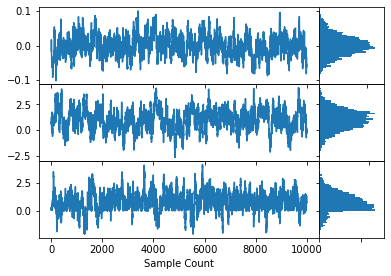

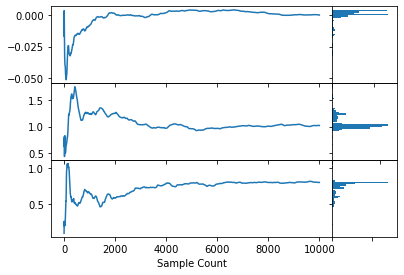

In [5]:
traceplots(np.array(abQ_samples))
traceplots(np.array(abQ_means))

[8.00201913e-01 1.01981614e+00 2.37924856e-04]


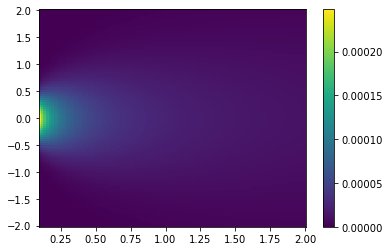

In [30]:
abQ_mean = abQ_means[-1]
x = np.linspace(0.1,2,101)
y = np.linspace(-2,2,101)
z = np.linspace(0,400,101)
X,Y = np.meshgrid(x,y)
Z = 0
C = C_func(X,Y,Z,u,abQ_mean[0],abQ_mean[1],abQ_mean[2],H)
plt.pcolor(X,Y,C,shading='auto')
plt.colorbar()
print(abQ_mean)


In [41]:
def RMS_func(abQ,u,H,all_data,sigma_data):
    MS = 0
    for i in range(all_data.shape[0]):
        x = all_data['x'].values[i]
        y = all_data['y'].values[i]
        z = all_data['z'].values[i]
        C = all_data['Concentration'].values[i]*0.01**3
        MS_single = (C_func(x,y,z,u,abQ[0],abQ[1],abQ[2],H)-C)**2
        MS+=MS_single
    RMS = np.sqrt(MS)
    return RMS

print('RMSE = '+str(RMS_func(abQ_mean,u,H,all_data,sigma_data)))

# # saving_samples = pd.DataFrame({'a':abQ_samples[:,0],'b':abQ_samples[:,1],'Q':abQ_samples[:,2]})
# saving_samples = pd.DataFrame(abQ_samples,columns=['a','b','Q'])
# saving_samples.to_csv('samples.csv')

RMSE = 0.07697824224013156


PermissionError: [Errno 13] Permission denied: 'samples.csv'

In [40]:
def print_vals(abQ_samples):
    abQ_samples = np.array(abQ_samples)
    vals = ['a','b','Q']
    for i in range(abQ_samples.shape[1]):
        print(vals[i]+' = '+str(np.mean(abQ_samples[:,i]))+' +/- '+str(np.std(abQ_samples[:,i])))
        
print_vals(abQ_samples)

a = 0.8002019133574212 +/- 0.8394388534488654
b = 1.0198161433039477 +/- 1.0177021072714212
Q = 0.00023792485647035209 +/- 0.0307478009179088
